In [2]:
from tensorflow import keras
from keras import layers
from pathlib import Path
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import json

In [3]:

DATADIR = "data/english_sentence_no_meta_tags"
GLOVE_BASE_DIR = "data/"

params = {
    'dim_chars': 100,
    'dim': 300,
    'dropout': 0.5,
    'epochs': 25,
    'batch_size': 20,
    'filters': 30,
    'kernel_size': 3,
    'lstm_size': 200,
    'optimizer': 'adam',
    'metrics': ['acc'],
    'standardize': None, 
#     'standardize': 'lower_and_strip_punctuation',
    'model_path': str(Path(DATADIR, 'model.h5')),
    'model_cnn_bilstm_crf_path': str(Path(DATADIR, 'model_cnn_bilstm_crf')),
    'model_cnn_bilstm_dn_crf_path': str(Path(DATADIR, 'model_cnn_bilstm_dn_crf')),
    'model_bilstm_crf_path': str(Path(DATADIR, 'model_bilstm_crf')),
    'model_bilstm_dn_crf_path': str(Path(DATADIR, 'model_bilstm_dn_crf')),
    'full_model_cnn_bilstm_crf_path': str(Path(DATADIR, 'full_model_cnn_bilstm_crf')),
    'full_model_cnn_bilstm_dn_crf_path': str(Path(DATADIR, 'full_model_cnn_bilstm_dn_crf')),
    'full_model_bilstm_crf_path': str(Path(DATADIR, 'full_model_bilstm_crf')),
    'full_model_bilstm_dn_crf_path': str(Path(DATADIR, 'full_model_bilstm_dn_crf')),
    'model_histories_path': str(Path(DATADIR)),
    'words_path': str(Path(DATADIR, 'vocab.words.txt')),
    'chars_path': str(Path(DATADIR, 'vocab.chars.txt')),
    'tags_path': str(Path(DATADIR, 'vocab.tags.txt')),
    'sentences_path': (str(Path(DATADIR, 'train.words.txt')), str(Path(DATADIR, 'testa.words.txt')), str(Path(DATADIR, 'testb.words.txt'))),
    'labels_path': (str(Path(DATADIR, 'train.tags.txt')), str(Path(DATADIR, 'testa.tags.txt')), str(Path(DATADIR, 'testb.tags.txt'))),
    'glove_path': str(Path(DATADIR, 'glove.npz')),
    'glove_raw_path': str(Path(GLOVE_BASE_DIR, 'glove.840B.300d.txt')),
    'char_vectorization_path': str(Path(DATADIR, 'char_vectorization.npz'))
}

In [4]:
def load_processed_files(params: dict):
    # Loading preprocessed files

    # Load vocab
    with Path(params["words_path"]).open() as f:
        word_to_idx = {}
        idx_to_word = {}
        for idx, line in enumerate(f):
            word = line.strip()
            word_to_idx[word] = idx
            idx_to_word[idx] = word

    size_vocab = len(word_to_idx)
    params['vocab_size'] = size_vocab
    print("vocab_size", size_vocab)

    # Load chars
    with Path(params["chars_path"]).open() as f:
        char_to_idx = {}
        idx_to_char = []
        for idx, line in enumerate(f):
            char = line.strip()
            char_to_idx[char] = idx
            idx_to_char.append(char)

    size_chars = len(char_to_idx)
    print("Char amount", size_chars)
    params['char_amount'] = size_chars
    params['chars'] = idx_to_char

    # Load tags
    with Path(params["tags_path"]).open() as f:
        tag_to_idx = {}
        idx_to_tag = {}
        for idx, line in enumerate(f):
            tag = line.strip()
            tag_to_idx[tag] = idx
            idx_to_tag[idx] = tag
    size_tags = len(tag_to_idx)
    print("Tag amount", size_tags)
    params['tag_amount'] = size_tags


    max_sent_size = 0
    max_word_size = 0

    for path in params["sentences_path"]:
        with Path(path).open() as f:
            for sentence in f:
                sentence = sentence.split(' ')
                for word in sentence:
                    max_word_size = max(max_word_size, len(word))
                max_sent_size = max(max_sent_size, len(sentence))

    print("Max word size", max_word_size)
    print("Max sentence size", max_sent_size)

    params['max_sent_size'] = max_sent_size
    params['max_word_size'] = max_word_size

load_processed_files(params)

vocab_size 8418
Char amount 83
Tag amount 4
Max word size 18
Max sentence size 73


In [5]:

def load_dataset_string(params:dict):
    # Loading dataset

    train_sentences = [x for x in Path(params['sentences_path'][0]).read_text().splitlines()]
    testa_sentences = [x for x in Path(params['sentences_path'][1]).read_text().splitlines()]
    testb_sentences = [x for x in Path(params['sentences_path'][2]).read_text().splitlines()]

    train_labels = [x.strip() for x in Path(params['labels_path'][0]).read_text().splitlines()]
    testa_labels = [x.strip() for x in Path(params['labels_path'][1]).read_text().splitlines()]
    testb_labels = [x.strip() for x in Path(params['labels_path'][2]).read_text().splitlines()]

    params['train_sentences'] = train_sentences
    params['testa_sentences'] = testa_sentences
    params['testb_sentences'] = testb_sentences
    
    params['train_labels'] = train_labels
    params['testa_labels'] = testa_labels
    params['testb_labels'] = testb_labels
    
load_dataset_string(params)

In [6]:

def add_vectorizers(params: dict):
    
    # Sentence vectorizer
    vectorizer = layers.TextVectorization(
        max_tokens=params["vocab_size"] + 2, # Plus PAD and UNK
        output_sequence_length=params["max_sent_size"],
        standardize=params['standardize'],
        split="whitespace",
    )
    
    train_sentences = params['train_sentences']
    testa_sentences = params['testa_sentences']
    testb_sentences = params['testb_sentences']
    
    text_ds = tf.data.Dataset.from_tensor_slices(train_sentences + testa_sentences + testb_sentences).batch(params["batch_size"])
    vectorizer.adapt(text_ds)
    params['vectorizer_sentence'] = vectorizer

    # Tags vectorizer
    vectorizer_tags = layers.TextVectorization(
        max_tokens=params["tag_amount"] + 2, # Plus PAD and UNK
        output_sequence_length=params["max_sent_size"],
        standardize=params['standardize'],
        split="whitespace",
    )
    
    train_labels = params['train_labels']
    testa_labels = params['testa_labels']
    testb_labels = params['testb_labels']
    tags_ds = tf.data.Dataset.from_tensor_slices(train_labels + testa_labels + testb_labels).batch(params["batch_size"])
    vectorizer_tags.adapt(tags_ds)
    params['vectorizer_tags'] = vectorizer_tags
    
    # Char vectorizer
    vectorizer_chars = layers.TextVectorization(
        max_tokens=params["char_amount"] + 2, # Plus PAD and UNK
        output_sequence_length=params["max_word_size"],
        standardize=params['standardize'],
        split="character"
    )
    
    chars = params['chars']
    
    vectorizer_chars.adapt(chars)
    
    params['vectorizer_chars'] = vectorizer_chars
    
    
    # Checking vectorizer

    # 0 -> Padding
    # 1 -> Out Of Vocabulary

    output = vectorizer([["los atletas les pagan en exceso"]])
    print(output.numpy()[0, :6])

    output = vectorizer([["ascas atletas"]])
    print(output.numpy()[0, :])

    output = vectorizer_tags([["O O a B-Claim I-Claim"]])
    print(output.numpy()[0, :6])

    output = vectorizer_tags([["ascas atletas"]])
    print(output.numpy()[0, :])
    
    output = vectorizer_chars([["asv v d s"]])
    print(output.numpy()[0, :6])

    output = vectorizer_chars([["/ 3 & 6"]])
    print(output.numpy()[0, :])
    
    
    
add_vectorizers(params)

[   1    1 6278    1    1    1]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[3 3 1 1 1 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[33 15 12  1 12  1]
[73  1 69  1 81  1 66  0  0  0  0  0  0  0  0  0  0  0]


In [7]:

def add_word_to_index(params: dict):
    vectorizer = params["vectorizer_sentence"]
    
    # Index to word and Word to index
    
    # Sentences
    voc = vectorizer.get_vocabulary()
    word_index = dict(zip(voc, range(len(voc))))
    params["words"] = voc
    params["word_index"] = word_index

    print("Vocab size", len(voc))
    print(params['words'][:10])
    params['vocab_size'] = len(voc) - 2 # Minus PAD and UNK
    
    # Tags
    vectorizer_tags = params["vectorizer_tags"]
    tags = vectorizer_tags.get_vocabulary()
    tag_index = dict(zip(tags, range(len(tags))))
    params["tags"] = tags
    params["tag_index"] = tag_index

    print("Tag amount", len(tags))
    print(params['tags'])
    params['tag_amount'] = len(tags) - 2 # Minus PAD and UNK

    # Chars
    vectorizer_chars = params["vectorizer_chars"]
    chars = vectorizer_chars.get_vocabulary()
    char_index = dict(zip(chars, range(len(chars))))
    params["chars"] = chars
    params["char_index"] = char_index

    print("Char amount", len(chars))
    print(params['chars'])
    params['char_amount'] = len(chars) - 2 # Minus PAD and UNK

add_word_to_index(params)


Vocab size 8408
['', '[UNK]', ',', '.', 'the', 'to', 'of', 'and', 'a', 'in']
Tag amount 6
['', '[UNK]', 'I', 'O', 'E', 'B']
Char amount 85
['', '[UNK]', '”', '“', '’', '‘', '–', 'é', 'z', 'y', 'x', 'w', 'v', 'u', 't', 's', 'r', 'q', 'p', 'o', 'n', 'm', 'l', 'k', 'j', 'i', 'h', 'g', 'f', 'e', 'd', 'c', 'b', 'a', 'Z', 'Y', 'X', 'W', 'V', 'U', 'T', 'S', 'R', 'Q', 'P', 'O', 'N', 'M', 'L', 'K', 'J', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A', '?', ';', ':', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0', '/', '.', '-', ',', '+', ')', '(', "'", '&', '%', '"', '!']


In [8]:


def loading_glove(params: dict):
    
    if Path(params["glove_path"]).exists():
        print("Glove Embedding Matrix Found")
        embedding_matrix = np.load(params["glove_path"])["embeddings"]
        params['embedding_matrix'] = embedding_matrix
        return
    
    # Loading Glove
    hits = 0
    misses = 0
    num_tokens = len(params['words']) # Plus padding and unknown 
    embedding_dim = params['dim']
    size_vocab = params['vocab_size']
    word_index = params['word_index']

    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    with Path(params["glove_raw_path"]).open() as f:
        for line_idx, line in enumerate(f):
            if line_idx % 100000 == 0:
                print('- At line {}'.format(line_idx))
            line = line.strip().split()
            if len(line) != 300 + 1:
                continue
            word = line[0]
            embedding = line[1:]
            if word in word_index:
                hits += 1
                word_idx = word_index[word]
                embedding_matrix[word_idx] = embedding
    print('- done. Found {} vectors for {} words'.format(hits, size_vocab))
    
    params['embedding_matrix'] = embedding_matrix
    np.savez_compressed(params["glove_path"], embeddings=embedding_matrix)

loading_glove(params)


- At line 0
- At line 100000
- At line 200000
- At line 300000
- At line 400000
- At line 500000
- At line 600000
- At line 700000
- At line 800000
- At line 900000
- At line 1000000
- At line 1100000
- At line 1200000
- At line 1300000
- At line 1400000
- At line 1500000
- At line 1600000
- At line 1700000
- At line 1800000
- At line 1900000
- At line 2000000
- At line 2100000
- done. Found 8336 vectors for 8406 words


In [9]:
def vectorize_char_sentence(params: dict, sentence: str):
    vectorizer_chars = params["vectorizer_chars"]
    max_sent_size = params["max_sent_size"]
    words = sentence.split(" ")
    word_padding = max_sent_size - len(words) 
    return vectorizer_chars([word for word in words] + ["" for _ in range(word_padding)])

def encode_sentence(params: dict, sentence: str, with_chars: bool):
    vectorizer_sentence = params['vectorizer_sentence']
    vectorizer_chars = params["vectorizer_chars"]
    
    sentence_vector = vectorizer_sentence(sentence)
    if with_chars:
        char_vector = vectorize_char_sentence(params, sentence)
        return sentence_vector, char_vector
    return sentence_vector

def convert_dataset_to_trainable_data(params: dict):
    
    # Sentences
    
    train_sentences = params['train_sentences']
    testa_sentences = params['testa_sentences']
    testb_sentences = params['testb_sentences']

    vectorizer = params['vectorizer_sentence']
    
    x_train = np.array([encode_sentence(params, s, False) for s in train_sentences]) 
    x_test = np.array([encode_sentence(params, s, False) for s in testa_sentences]) 
    x_val = np.array([encode_sentence(params, s, False) for s in testb_sentences]) 

    params['x_train'] = x_train
    params['x_test'] = x_test
    params['x_val'] = x_val
    
    # Tags

    train_labels = params['train_labels']
    testa_labels = params['testa_labels']
    testb_labels = params['testb_labels']
    
    vectorizer_tags = params['vectorizer_tags']
    
    y_train = vectorizer_tags(np.array([x for x in train_labels])).numpy()
    y_test = vectorizer_tags(np.array([x for x in testa_labels])).numpy()
    y_val = vectorizer_tags(np.array([x for x in testb_labels])).numpy()

    params["y_train"] = y_train
    params["y_test"] = y_test
    params["y_val"] = y_val
    
    
    # Chars
    
    char_vectorization_path = params["char_vectorization_path"]
    
    if Path(char_vectorization_path).exists():
        array_lists = np.load(char_vectorization_path)
        x_train_char = array_lists["train"]
        params['x_train_char'] = array_lists["train"]
        params['x_test_char'] = array_lists["test"]
        params['x_val_char'] = array_lists["val"]
    else:
        vectorizer_chars = params["vectorizer_chars"]
        max_sent_size = params["max_sent_size"]


        x_train_char = np.array(
            [vectorize_char_sentence(params, sentence) for sentence in train_sentences])
        x_test_char = np.array(
            [vectorize_char_sentence(params, sentence) for sentence in testa_sentences])
        x_val_char = np.array(
            [vectorize_char_sentence(params, sentence) for sentence in testb_sentences])

        params['x_train_char'] = x_train_char
        params['x_test_char'] = x_test_char
        params['x_val_char'] = x_val_char

        np.savez_compressed(char_vectorization_path, train=x_train_char, test=x_test_char, val=x_val_char)
    

    print(x_train.shape)
    print(x_train_char.shape)
    print(y_train.shape)
    print(x_train[0])
    print(x_train_char[0])
    print(y_train[0])

convert_dataset_to_trainable_data(params)


(5096, 73)
(5096, 73, 18)
(5096, 73)
[ 831   32   16  740    5 2530   28    5 1637  179    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
[[41 26 19 ...  0  0  0]
 [15 14 13 ...  0  0  0]
 [32 29  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
[3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:

def create_model_bilstm_crf(params: dict):

    words_amount = len(params['words']) # Plus padding and unknown 
    embedding_dim = params['dim']
    embedding_matrix = params['embedding_matrix']
    max_sentence_size = params['max_sent_size']
    lstm_size = params["lstm_size"]
    tag_amount = len(params['tags']) # Plus padding and unknown 
    optimizer = params['optimizer']
    metrics = params['metrics']
    dropout = params['dropout']

    # Input layer
    int_sequences_input = keras.Input(shape=(max_sentence_size,), dtype="int64")
    
    # Embedding layer, convert an index vector into a embedding vector, by accessing embedding_matrix
    embedding_layer = layers.Embedding(
        words_amount,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        input_length=max_sentence_size
    )

    embedded_sequences = embedding_layer(int_sequences_input)

    # BiLSTM Layer
    model_layers = layers.Bidirectional(layers.LSTM(
        lstm_size, 
        return_sequences=True))(embedded_sequences)

    # Dropout layer
    model_layers = layers.Dropout(dropout)(model_layers)
    
    # Model
    model = keras.Model(int_sequences_input, model_layers)
    model.summary()
    
    # CRF layer
    model = tfa.text.crf_wrapper.CRFModelWrapper(model, tag_amount)
    model.compile(
        optimizer=optimizer, 
        metrics=metrics
    )
    
    params["model"] = model
    params["model_bilstm_crf"] = model

create_model_bilstm_crf(params)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 73)]              0         
                                                                 
 embedding (Embedding)       (None, 73, 300)           2522400   
                                                                 
 bidirectional (Bidirectiona  (None, 73, 400)          801600    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 73, 400)           0         
                                                                 
Total params: 3,324,000
Trainable params: 801,600
Non-trainable params: 2,522,400
_________________________________________________________________


In [11]:

def create_model_bilstm_dn_crf(params: dict):

    words_amount = len(params['words']) # Plus padding and unknown 
    embedding_dim = params['dim']
    embedding_matrix = params['embedding_matrix']
    max_sentence_size = params['max_sent_size']
    lstm_size = params["lstm_size"]
    tag_amount = len(params['tags']) # Plus padding and unknown 
    optimizer = params['optimizer']
    metrics = params['metrics']
    dropout = params['dropout']

    # Input layer
    int_sequences_input = keras.Input(shape=(max_sentence_size,), dtype="int64")
    
    # Embedding layer, convert an index vector into a embedding vector, by accessing embedding_matrix
    embedding_layer = layers.Embedding(
        words_amount,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        input_length=max_sentence_size
    )

    embedded_sequences = embedding_layer(int_sequences_input)

    # BiLSTM Layer
    model_layers = layers.Bidirectional(layers.LSTM(
        lstm_size, 
        return_sequences=True))(embedded_sequences)
  
    # Dropout layer
    model_layers = layers.Dropout(dropout)(model_layers) # TODO This layer isn't in the original model
   
    # Dense layer
    model_layers = layers.TimeDistributed(layers.Dense(50))(model_layers) # TODO This layer isn't in the original model
    
    # Dropout layer
    model_layers = layers.Dropout(dropout)(model_layers)
    
    # Model
    model = keras.Model(int_sequences_input, model_layers)
    model.summary()
    
    # CRF layer
    model = tfa.text.crf_wrapper.CRFModelWrapper(model, tag_amount)
    model.compile(
        optimizer=optimizer, 
        metrics=metrics
    )
    
    params["model"] = model
    params["model_bilstm_dn_crf"] = model

create_model_bilstm_dn_crf(params)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 73)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 73, 300)           2522400   
                                                                 
 bidirectional_1 (Bidirectio  (None, 73, 400)          801600    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 73, 400)           0         
                                                                 
 time_distributed (TimeDistr  (None, 73, 50)           20050     
 ibuted)                                                         
                                                                 
 dropout_2 (Dropout)         (None, 73, 50)            0   

In [12]:

def train_and_save_model_no_cnn(params: dict, model_name='model'):
    
    epochs = params['epochs']
    batch_size = params['batch_size']
    model = params[model_name]
    x_train, y_train = params['x_train'], params['y_train']
    x_val, y_val = params['x_val'], params['y_val']
    
    history = model.fit(x_train, y_train, 
              batch_size=batch_size, 
              epochs=epochs, 
              validation_data=(x_val, y_val))
    
    model.save(params[f"{model_name}_path"], save_format='tf')
    with Path(params['model_histories_path'], f"{model_name}_history.json").open('w') as f:
        json.dump(history.history, f)
    

model_name = "model_bilstm_crf"
train_and_save_model_no_cnn(params, model_name)

model_name = "model_bilstm_dn_crf"
train_and_save_model_no_cnn(params, model_name)


Epoch 1/25
255/255 [==============================] - 88s 293ms/step - acc: 0.3905 - loss: 13.9284 - crf_loss: 13.9284 - val_acc: 0.5567 - val_loss: 7.0804 - val_crf_loss: 7.0804
Epoch 2/25
255/255 [==============================] - 75s 293ms/step - acc: 0.6523 - loss: 7.2173 - crf_loss: 7.2173 - val_acc: 0.7061 - val_loss: 4.6093 - val_crf_loss: 4.6093
Epoch 3/25
255/255 [==============================] - 72s 283ms/step - acc: 0.7474 - loss: 5.3033 - crf_loss: 5.3033 - val_acc: 0.7915 - val_loss: 2.7825 - val_crf_loss: 2.7825
Epoch 4/25
255/255 [==============================] - 74s 289ms/step - acc: 0.8000 - loss: 3.9917 - crf_loss: 3.9917 - val_acc: 0.7997 - val_loss: 3.7766 - val_crf_loss: 3.7766
Epoch 5/25
255/255 [==============================] - 74s 289ms/step - acc: 0.8336 - loss: 3.1884 - crf_loss: 3.1884 - val_acc: 0.8161 - val_loss: 2.7333 - val_crf_loss: 2.7333
Epoch 6/25
255/255 [==============================] - 73s 288ms/step - acc: 0.8607 - loss: 2.5721 - crf_loss: 2.5

INFO:tensorflow:Assets written to: data/english_no_meta_tags/model_bilstm_crf/assets


INFO:tensorflow:Assets written to: data/english_no_meta_tags/model_bilstm_crf/assets


Epoch 1/25
255/255 [==============================] - 83s 297ms/step - acc: 0.3760 - loss: 16.4075 - crf_loss: 16.4075 - val_acc: 0.4319 - val_loss: 12.6148 - val_crf_loss: 12.6148
Epoch 2/25
255/255 [==============================] - 74s 290ms/step - acc: 0.6181 - loss: 7.6678 - crf_loss: 7.6678 - val_acc: 0.7291 - val_loss: 3.2507 - val_crf_loss: 3.2507
Epoch 3/25
255/255 [==============================] - 73s 285ms/step - acc: 0.7384 - loss: 5.5271 - crf_loss: 5.5271 - val_acc: 0.7619 - val_loss: 2.2948 - val_crf_loss: 2.2948
Epoch 4/25
255/255 [==============================] - 74s 292ms/step - acc: 0.7920 - loss: 4.2165 - crf_loss: 4.2165 - val_acc: 0.7980 - val_loss: 1.9091 - val_crf_loss: 1.9091
Epoch 5/25
255/255 [==============================] - 73s 285ms/step - acc: 0.8252 - loss: 3.3988 - crf_loss: 3.3988 - val_acc: 0.8161 - val_loss: 2.0939 - val_crf_loss: 2.0939
Epoch 6/25
255/255 [==============================] - 74s 291ms/step - acc: 0.8548 - loss: 2.7627 - crf_loss: 2

INFO:tensorflow:Assets written to: data/english_no_meta_tags/model_bilstm_dn_crf/assets


INFO:tensorflow:Assets written to: data/english_no_meta_tags/model_bilstm_dn_crf/assets


In [13]:
    
def evaluate_model_no_cnn(params: dict, model_name='model'):
    batch_size = params['batch_size']
    model = params[model_name]
    x_test, y_test = params['x_test'], params['y_test']
    
    results = model.evaluate(x_test, y_test, batch_size=batch_size)
    print("test loss, test acc", results)

model_name = "model_bilstm_dn_crf"
evaluate_model_no_cnn(params, model_name)

model_name = "model_bilstm_crf"
evaluate_model_no_cnn(params, model_name)
    

73/73 [==============================] - 5s 72ms/step - acc: 0.8733 - loss: 3.6694 - crf_loss: 3.6694
test loss, test acc [0.8732782602310181, 6.192911624908447, 6.192911624908447]
73/73 [==============================] - 5s 71ms/step - acc: 0.8795 - loss: 3.4777 - crf_loss: 3.4777
test loss, test acc [0.8794766068458557, 3.525787353515625, 3.525787353515625]


In [14]:

def create_model_cnn_bilstm_dn_crf(params: dict):

    words_amount = len(params['words']) # Plus padding and unknown 
    embedding_dim = params['dim']
    embedding_matrix = params['embedding_matrix']
    max_sentence_size = params['max_sent_size']
    lstm_size = params["lstm_size"]
    tag_amount = len(params['tags']) # Plus padding and unknown 
    optimizer = params['optimizer']
    metrics = params['metrics']
    dropout = params['dropout']
    
    dim_chars = params["dim_chars"]
    filters = params['filters']
    kernel_size = params["kernel_size"]
    max_word_size = params['max_word_size']
    batch_size = params['batch_size']
    char_index = params['char_index']
    chars = params['chars']
    char_amount = len(chars) # Plus padding and unknown
    
    # Input layer char
    int_char_input = keras.Input(shape=(max_word_size,), dtype="int64")
    
    # Embedding layer char
    embedding_char_layer = layers.Embedding(
        char_amount,
        dim_chars,
        trainable=True,
        input_length=max_word_size
    )
    
    embedded_chars = embedding_char_layer(int_char_input)
    
    # Dropout layer char
    model_char_layers = layers.Dropout(dropout)(embedded_chars)
   
    # Convolution Layer char
    
    model_char_layers = layers.Conv1D(
        filters,
        kernel_size,
        padding="same",
        input_shape=(max_word_size, dim_chars)
    )(model_char_layers)
    
    # Max Polling layer char

    model_char_layers = layers.MaxPooling1D(
        max_word_size,
        input_shape=(max_word_size, filters)
    )(model_char_layers)
    
    # Reshape layer char
    
    model_char_layers = layers.Reshape((filters,), input_shape=(1, filters))(model_char_layers)
    
    char_model = keras.Model(int_char_input, model_char_layers)
    
    char_model.summary()
    
    # Time Distributed with words
    inputs_word_chars = keras.Input(shape=(max_sentence_size, max_word_size), dtype="int64")
    model_char_layers = layers.TimeDistributed(char_model)(inputs_word_chars)
    
    # Dropout layer
    model_char_layers = layers.Dropout(dropout)(model_char_layers)
   
    
    # Input layer
    int_sequences_input = keras.Input(shape=(max_sentence_size,), dtype="int64")
    
    # Embedding layer, convert an index vector into a embedding vector, by accessing embedding_matrix
    embedding_layer = layers.Embedding(
        words_amount,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        input_length=max_sentence_size
    )

    embedded_sequences = embedding_layer(int_sequences_input)
    
    # Concatenate char embedding with sentence embedding
    model_layers = layers.Concatenate()([embedded_sequences, model_char_layers])
    
    # BiLSTM Layer
    model_layers = layers.Bidirectional(layers.LSTM(
        lstm_size, 
        return_sequences=True))(model_layers)
  
    # Dropout layer
    model_layers = layers.Dropout(dropout)(model_layers)
   
    # Dense layer
    model_layers = layers.TimeDistributed(layers.Dense(50))(model_layers)

    # Dropout layer
    model_layers = layers.Dropout(dropout)(model_layers)
    
    # Model
    model = keras.Model([int_sequences_input, inputs_word_chars], model_layers)
    model.summary()
    
    # CRF layer
    model = tfa.text.crf_wrapper.CRFModelWrapper(model, tag_amount)
    model.compile(
        optimizer=optimizer, 
        metrics=metrics
    )
    
    params["model"] = model
    params["model_cnn_bilstm_dn_crf"] = model

create_model_cnn_bilstm_dn_crf(params)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 18)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 18, 100)           8500      
                                                                 
 dropout_3 (Dropout)         (None, 18, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 18, 30)            9030      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 30)            0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 30)                0         
                                                           

In [15]:

def create_model_cnn_bilstm_crf(params: dict):

    words_amount = len(params['words']) # Plus padding and unknown 
    embedding_dim = params['dim']
    embedding_matrix = params['embedding_matrix']
    max_sentence_size = params['max_sent_size']
    lstm_size = params["lstm_size"]
    tag_amount = len(params['tags']) # Plus padding and unknown 
    optimizer = params['optimizer']
    metrics = params['metrics']
    dropout = params['dropout']
    
    dim_chars = params["dim_chars"]
    filters = params['filters']
    kernel_size = params["kernel_size"]
    max_word_size = params['max_word_size']
    batch_size = params['batch_size']
    char_index = params['char_index']
    chars = params['chars']
    char_amount = len(chars) # Plus padding and unknown
    
    # Input layer char
    int_char_input = keras.Input(shape=(max_word_size,), dtype="int64")
    
    # Embedding layer char
    embedding_char_layer = layers.Embedding(
        char_amount,
        dim_chars,
        trainable=True,
        input_length=max_word_size
    )
    
    embedded_chars = embedding_char_layer(int_char_input)
    
    # Dropout layer char
    model_char_layers = layers.Dropout(dropout)(embedded_chars)
   
    # Convolution Layer char
    
    model_char_layers = layers.Conv1D(
        filters,
        kernel_size,
        padding="same",
        input_shape=(max_word_size, dim_chars)
    )(model_char_layers)
    
    # Max Polling layer char

    model_char_layers = layers.MaxPooling1D(
        max_word_size,
        input_shape=(max_word_size, filters)
    )(model_char_layers)
    
    # Reshape layer char
    
    model_char_layers = layers.Reshape((filters,), input_shape=(1, filters))(model_char_layers)
    
    char_model = keras.Model(int_char_input, model_char_layers)
    
    char_model.summary()
    
    # Time Distributed with words
    inputs_word_chars = keras.Input(shape=(max_sentence_size, max_word_size), dtype="int64")
    model_char_layers = layers.TimeDistributed(char_model)(inputs_word_chars)
    
    # Dropout layer
    model_char_layers = layers.Dropout(dropout)(model_char_layers)
   
    
    # Input layer
    int_sequences_input = keras.Input(shape=(max_sentence_size,), dtype="int64")
    
    # Embedding layer, convert an index vector into a embedding vector, by accessing embedding_matrix
    embedding_layer = layers.Embedding(
        words_amount,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        input_length=max_sentence_size
    )

    embedded_sequences = embedding_layer(int_sequences_input)
    
    # Concatenate char embedding with sentence embedding
    model_layers = layers.Concatenate()([embedded_sequences, model_char_layers])
 
    # BiLSTM Layer
    model_layers = layers.Bidirectional(layers.LSTM(
        lstm_size, 
        return_sequences=True))(model_layers)
  
    # Dropout layer
    model_layers = layers.Dropout(dropout)(model_layers)
    
    # Model
    model = keras.Model([int_sequences_input, inputs_word_chars], model_layers)
    model.summary()
    
    # CRF layer
    model = tfa.text.crf_wrapper.CRFModelWrapper(model, tag_amount)
    model.compile(
        optimizer=optimizer, 
        metrics=metrics
    )
    
    params["model"] = model
    params["model_cnn_bilstm_crf"] = model

create_model_cnn_bilstm_crf(params)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 18)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 18, 100)           8500      
                                                                 
 dropout_7 (Dropout)         (None, 18, 100)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 30)            9030      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 30)            0         
 1D)                                                             
                                                                 
 reshape_1 (Reshape)         (None, 30)                0         
                                                           

In [16]:

def train_and_save_model_cnn(params: dict, model_name='model'):
    
    epochs = params['epochs']
    batch_size = params['batch_size']
    model = params[model_name]
    x_train, x_train_char, y_train = params['x_train'], params['x_train_char'], params['y_train']
    x_val, x_val_char, y_val = params['x_val'], params['x_val_char'], params['y_val']
    history = model.fit([x_train, x_train_char], y_train, 
                  batch_size=batch_size, 
                  epochs=epochs, 
                  validation_data=([x_val, x_val_char], y_val))
    
    model.save(params[f"{model_name}_path"], save_format='tf')
    with Path(params['model_histories_path'], f"{model_name}_history.json").open('w') as f:
        json.dump(history.history, f)
    
    return model

model_name = "model_cnn_bilstm_dn_crf"
train_and_save_model_cnn(params, model_name)

model_name = "model_cnn_bilstm_crf"
model = train_and_save_model_cnn(params, model_name)



Epoch 1/25
255/255 [==============================] - 121s 436ms/step - acc: 0.3846 - loss: 18.6930 - crf_loss: 18.6930 - val_acc: 0.6289 - val_loss: 10.0328 - val_crf_loss: 10.0328
Epoch 2/25
255/255 [==============================] - 109s 429ms/step - acc: 0.6434 - loss: 9.8338 - crf_loss: 9.8338 - val_acc: 0.7406 - val_loss: 4.6814 - val_crf_loss: 4.6814
Epoch 3/25
255/255 [==============================] - 110s 430ms/step - acc: 0.7318 - loss: 7.2422 - crf_loss: 7.2422 - val_acc: 0.7635 - val_loss: 4.4938 - val_crf_loss: 4.4938
Epoch 4/25
255/255 [==============================] - 111s 435ms/step - acc: 0.7818 - loss: 5.4402 - crf_loss: 5.4402 - val_acc: 0.8144 - val_loss: 4.2513 - val_crf_loss: 4.2513
Epoch 5/25
255/255 [==============================] - 119s 465ms/step - acc: 0.8053 - loss: 4.2513 - crf_loss: 4.2513 - val_acc: 0.8128 - val_loss: 2.5060 - val_crf_loss: 2.5060
Epoch 6/25
255/255 [==============================] - 112s 438ms/step - acc: 0.8279 - loss: 3.4118 - crf_l

INFO:tensorflow:Assets written to: data/english_no_meta_tags/model_cnn_bilstm_dn_crf/assets


INFO:tensorflow:Assets written to: data/english_no_meta_tags/model_cnn_bilstm_dn_crf/assets


Epoch 1/25
255/255 [==============================] - 120s 437ms/step - acc: 0.4600 - loss: 15.2754 - crf_loss: 15.2754 - val_acc: 0.5731 - val_loss: 14.8968 - val_crf_loss: 14.8968
Epoch 2/25
255/255 [==============================] - 127s 499ms/step - acc: 0.7027 - loss: 8.1655 - crf_loss: 8.1655 - val_acc: 0.7406 - val_loss: 4.6847 - val_crf_loss: 4.6847
Epoch 3/25
255/255 [==============================] - 134s 525ms/step - acc: 0.7688 - loss: 6.0240 - crf_loss: 6.0240 - val_acc: 0.8079 - val_loss: 5.4967 - val_crf_loss: 5.4967
Epoch 4/25
255/255 [==============================] - 113s 444ms/step - acc: 0.8122 - loss: 4.6363 - crf_loss: 4.6363 - val_acc: 0.8342 - val_loss: 3.0959 - val_crf_loss: 3.0959
Epoch 5/25
255/255 [==============================] - 113s 444ms/step - acc: 0.8377 - loss: 3.6415 - crf_loss: 3.6415 - val_acc: 0.8292 - val_loss: 2.6764 - val_crf_loss: 2.6764
Epoch 6/25
255/255 [==============================] - 120s 471ms/step - acc: 0.8575 - loss: 2.9901 - crf_l

INFO:tensorflow:Assets written to: data/english_no_meta_tags/model_cnn_bilstm_crf/assets


INFO:tensorflow:Assets written to: data/english_no_meta_tags/model_cnn_bilstm_crf/assets


In [17]:
    
def evaluate_model_cnn(params: dict, model_name='model'):
    batch_size = params['batch_size']
    model = params[model_name]
    x_test, x_test_char, y_test = params['x_test'], params['x_test_char'], params['y_test']
    
    results = model.evaluate([x_test, x_test_char], y_test, batch_size=batch_size)
    print("test loss, test acc", results)

model_name = "model_cnn_bilstm_dn_crf"
evaluate_model_cnn(params, model_name)

model_name = "model_cnn_bilstm_crf"
evaluate_model_cnn(params, model_name)
    

73/73 [==============================] - 7s 91ms/step - acc: 0.8678 - loss: 4.9280 - crf_loss: 4.9280
test loss, test acc [0.8677685856819153, 8.735188484191895, 8.735188484191895]
73/73 [==============================] - 6s 83ms/step - acc: 0.8623 - loss: 5.8954 - crf_loss: 5.8954
test loss, test acc [0.8622589707374573, 7.82013463973999, 7.82013463973999]


dict_keys(['acc', 'loss', 'crf_loss', 'val_acc', 'val_loss', 'val_crf_loss'])


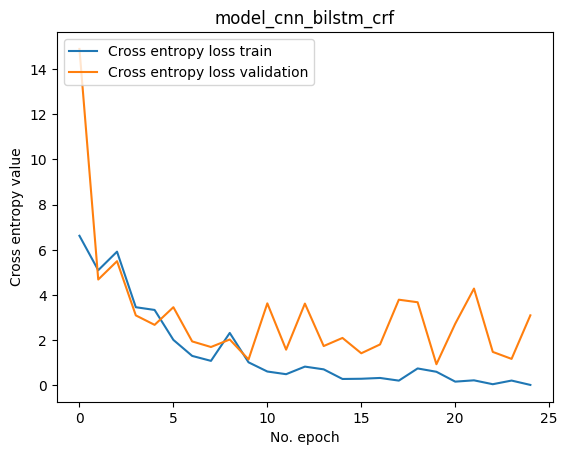

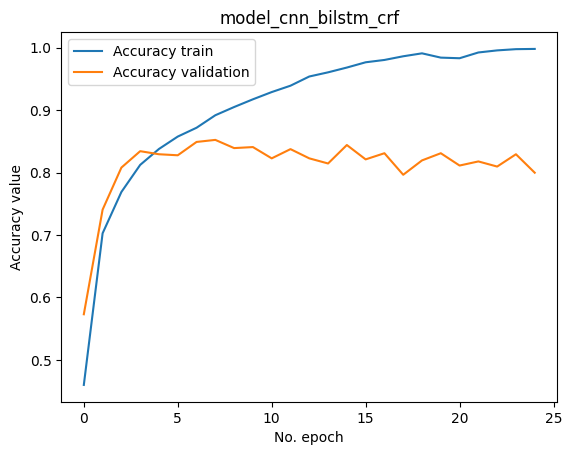

dict_keys(['acc', 'loss', 'crf_loss', 'val_acc', 'val_loss', 'val_crf_loss'])


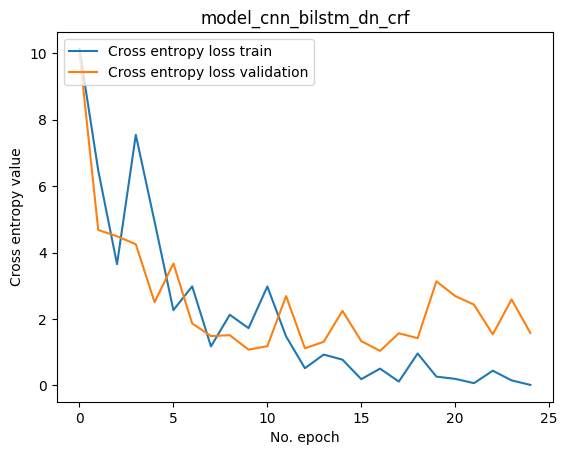

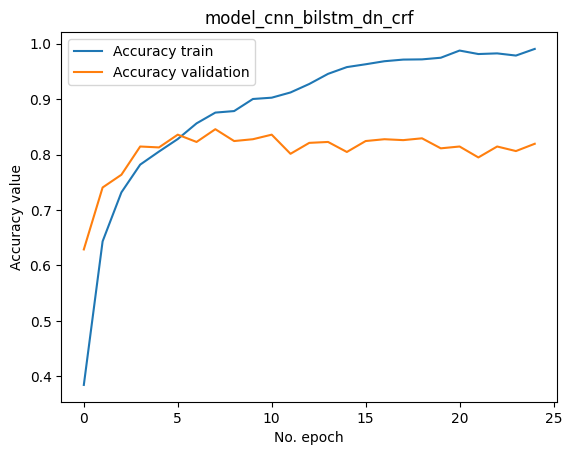

dict_keys(['acc', 'loss', 'crf_loss', 'val_acc', 'val_loss', 'val_crf_loss'])


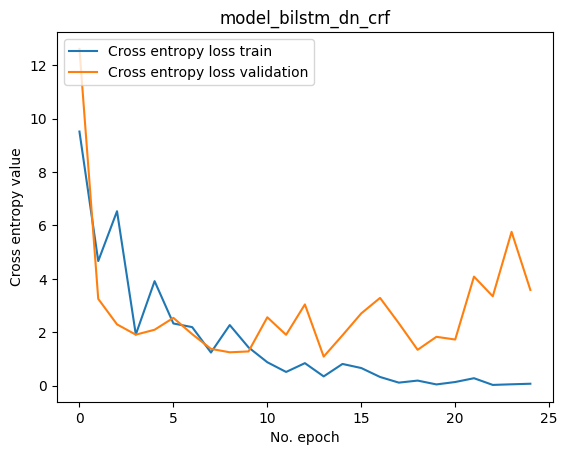

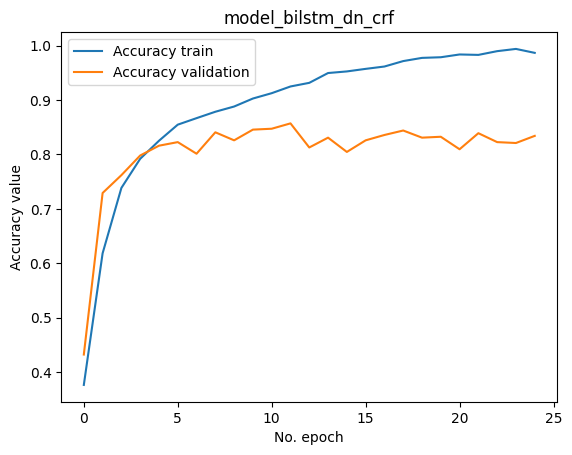

dict_keys(['acc', 'loss', 'crf_loss', 'val_acc', 'val_loss', 'val_crf_loss'])


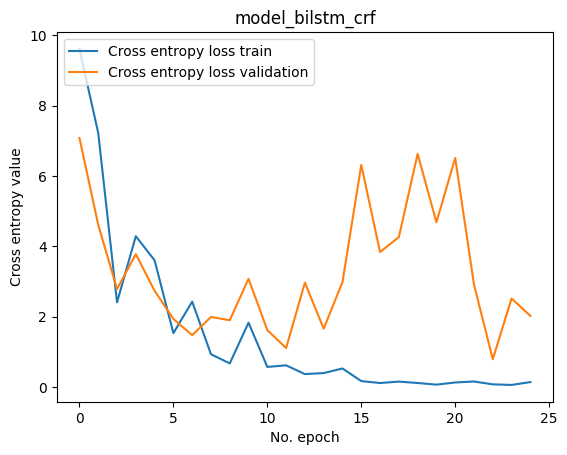

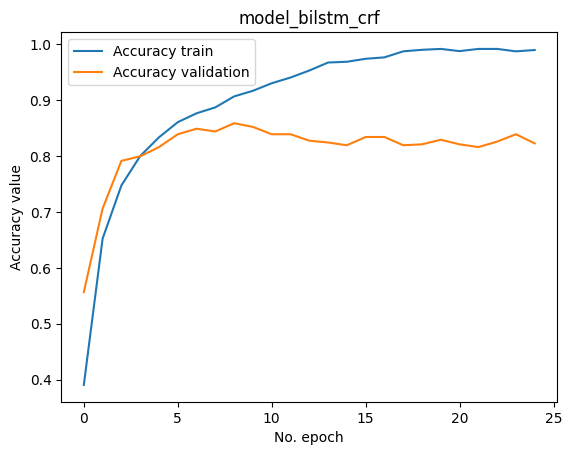

In [18]:
import matplotlib.pyplot as plt
def plot_history(title: str, path: Path):
    
    history = json.load(path.open())
    print(history.keys())
    
    plt.plot(history['loss'], label='Cross entropy loss train')
    plt.plot(history['val_loss'], label='Cross entropy loss validation')
    plt.title(title)
    plt.ylabel('Cross entropy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()
    
    plt.plot(history['acc'], label='Accuracy train')
    plt.plot(history['val_acc'], label='Accuracy validation')
    plt.title(title)
    plt.ylabel('Accuracy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

base_path = Path(params['model_histories_path'])

model_name = "model_cnn_bilstm_crf"
plot_history(model_name, base_path / f"{model_name}_history.json")

model_name = "model_cnn_bilstm_dn_crf"
plot_history(model_name, base_path / f"{model_name}_history.json")

model_name = "model_bilstm_dn_crf"
plot_history(model_name, base_path / f"{model_name}_history.json")

model_name = "model_bilstm_crf"
plot_history(model_name, base_path / f"{model_name}_history.json")


In [19]:
# Load models

def load_saved_model(params: dict, model_name):
    model = keras.models.load_model(params[f"{model_name}_path"])
    params[model_name] = model
    return model

# model_name = "model_cnn_bilstm_dn_crf"
# model_name = "model_cnn_bilstm_crf"
# model_name = "model_bilstm_dn_crf"
# model_name = "model_bilstm_crf"
# model = load_saved_model(params, model_name)


In [21]:
def decode_sentences(params: dict, sentenes:list, model_name:str):
    with_chars = "cnn" in model_name
    tags = params['tags']
    model = params[model_name]
    result = []
    for sentence in sentences:
        if with_chars:
            sentence_vector, char_vector = encode_sentence(params, sentence, with_chars)
            sentence_vector = sentence_vector.numpy().reshape(1,sentence_vector.shape[0])
            char_vector = char_vector.numpy().reshape(1, char_vector.shape[0], char_vector.shape[1])
            raw_tags = model([sentence_vector, char_vector])
        else:
            sentence_vector = encode_sentence(params, sentence, with_chars)
            sentence_vector = sentence_vector.numpy().reshape(1,sentence_vector.shape[0])
            raw_tags = model(sentence_vector)
        result.append([tags[t] for t in raw_tags[0]])
    return result

sentences = [
    "From this point of view , I firmly believe that we should attach more importance to cooperation during primary education .",
]

# model_name = "model_cnn_bilstm_dn_crf"
model_name = "model_cnn_bilstm_crf"
# model_name = "model_bilstm_dn_crf"
# model_name = "model_bilstm_crf"
print(decode_sentences(params, sentences, model_name))


[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MajorClaim', 'I-MajorClaim', 'I-MajorClaim', 'I-MajorClaim', 'I-MajorClaim', 'I-MajorClaim', 'I-MajorClaim', 'I-MajorClaim', 'I-MajorClaim', 'E-MajorClaim', 'O', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']]


In [20]:
class SequenceTagguerModel(keras.Model):
        
    def __init__(self, 
                 vocab_size, 
                 character_amount, 
                 max_sentence_size, 
                 max_word_size, 
                 tags_amount, 
                 model,
                 with_cnn,
                 standardize=None,
                 
                ):
        super().__init__()
        self.max_sentence_size = max_sentence_size
        self.max_word_size = max_word_size
        self.with_cnn = with_cnn
        
        # Sentence vectorizer
        self.vectorizer_sentence = layers.TextVectorization(
            max_tokens=vocab_size + 2, # Plus PAD and UNK
            output_sequence_length=max_sentence_size,
            standardize=standardize,
            split="whitespace",
        )

        # Tags vectorizer
        self.vectorizer_tags = layers.TextVectorization(
            max_tokens=tags_amount + 2, # Plus PAD and UNK
            output_sequence_length=max_sentence_size,
            standardize=standardize,
            split="whitespace",
        )

        # Char vectorizer
        self.vectorizer_chars = layers.TextVectorization(
            max_tokens=character_amount + 2, # Plus PAD and UNK
            output_sequence_length=max_word_size,
            standardize=None,
            split="character"
        )
        self.model = model

    def vectorize_char_sentence(self, sentence: str):
        words = tf.concat([tf.strings.split(sentence, " "), tf.repeat(b"", self.max_sentence_size)], 0)
        words = tf.slice(words, [0], [self.max_sentence_size])
        result = self.vectorizer_chars(words) 
        result = tf.reshape(result, [1, self.max_sentence_size, self.max_word_size])
        return result
        
    def encode_sentence(self, sentence: str):
        sentence_vector = self.vectorizer_sentence(sentence)
        sentence_vector = tf.reshape(sentence_vector, [1, self.max_sentence_size])
            
        if self.with_cnn:
            char_vector = self.vectorize_char_sentence(sentence)
            return sentence_vector, char_vector
        return sentence_vector

    def adapt(self, sentences, labels, chars):
        self.vectorizer_sentence.adapt(sentences)
        self.vectorizer_chars.adapt(chars)
        self.vectorizer_tags.adapt(labels)
    
    def call(self, inputs):
        
        def convert(sentence):
            if self.with_cnn:
                sentence_vector, char_vector = self.encode_sentence(sentence)
                raw_tags = self.model([sentence_vector, char_vector])
            else:
                sentence_vector = self.encode_sentence(sentence)
                raw_tags = self.model(sentence_vector)

            return raw_tags[0]
        return tf.map_fn(lambda x: convert(x), inputs, fn_output_signature=tf.TensorSpec([self.max_sentence_size], tf.int32))
    
    def fit(self, *args, **kwargs):
        return self.model

    
def load_full_model(params: dict, model_name: str):
    
    if model_name in params:
        model = params[model_name]
    else:
        model = load_saved_model(params, model_name)

    m = SequenceTagguerModel(
        vocab_size=params['vocab_size'],
        character_amount=params['char_amount'],
        max_sentence_size=params['max_sent_size'],
        max_word_size=params['max_word_size'],
        tags_amount=params['tag_amount'],
        model=model,
        with_cnn="cnn" in model_name,
        standardize=params['standardize']
    )

    text_ds = tf.data.TextLineDataset(params['sentences_path']).batch(params["batch_size"])
    tags_ds = tf.data.TextLineDataset(params["labels_path"]).batch(params["batch_size"])
    chars = tf.data.TextLineDataset(params["chars_path"]).batch(params["batch_size"])

    m.adapt(text_ds, tags_ds, chars)
    
    return m

# model_name = "model_cnn_bilstm_dn_crf"
model_name = "model_cnn_bilstm_crf"
# model_name = "model_bilstm_dn_crf"
# model_name = "model_bilstm_crf"
model = load_full_model(params, model_name)

In [21]:
print(model.vectorizer_tags.get_vocabulary())

data = tf.constant([
    "From this point of view , I firmly believe that we should attach more importance to cooperation during primary education .",
])

print(model(data))

model.save(params[f"full_{model_name}_path"])

['', '[UNK]', 'I', 'O', 'E', 'B']
tf.Tensor(
[[3 3 3 3 3 3 3 3 3 3 5 2 2 2 2 2 2 2 2 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0]], shape=(1, 73), dtype=int32)


INFO:tensorflow:Assets written to: data/english_no_meta_tags/full_model_cnn_bilstm_crf/assets


INFO:tensorflow:Assets written to: data/english_no_meta_tags/full_model_cnn_bilstm_crf/assets


In [22]:
model = keras.models.load_model(params[f"full_{model_name}_path"])

In [23]:
data = tf.constant([
    "From this point of view , I firmly believe that we should attach more importance to cooperation during primary education .",
])

print(model(data))

def decode_tags(model, tags_list):
    result = []
    index_to_tag = model.vectorizer_tags.get_vocabulary()
    for tags in tags_list:
        result.append([index_to_tag[i] for i in tags])
    return result

print(decode_tags(model, model(data)))

tf.Tensor(
[[3 3 3 3 3 3 3 3 3 3 5 2 2 2 2 2 2 2 2 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0]], shape=(1, 73), dtype=int32)
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'E', 'O', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']]
